# Project Name: Image Classification with TFLite

## Part 1: Dev's Profile

Nama: Tariq Fitria Aziz

Tanggal Bergabung: 2 September 2020

Asal: Wonogiri, Jawa Tengah

## Part 2: Import Libraries

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

from google.colab import files

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

import zipfile, gzip
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Part 3: Data Preparation

Dataset yang digunakan di sini adalah dataset "ASL Alphabet Language" yang dapat diunduh dari Kaggle. Dataset ini memiliki 87.000 gambar dengan resolusi 200x200 piksel, dengan total 29 kelas. <br>

<b>Sumber: https://www.kaggle.com/grassknoted/asl-alphabet

### Load Kaggle Dataset

In [2]:
! mkdir ~/.kaggle

In [3]:
! cp kaggle.json ~/.kaggle/

In [4]:
! chmod 600 ~/.kaggle/kaggle.json

In [5]:
! kaggle datasets download grassknoted/asl-alphabet

100% 1.02G/1.03G [00:06<00:00, 157MB/s]
100% 1.03G/1.03G [00:06<00:00, 169MB/s]


### Mengekstrak Dataset

In [6]:
zipfile_name = '/content/asl-alphabet.zip'
zip_read = zipfile.ZipFile(zipfile_name, 'r')
zip_read.extractall('/content')
zip_read.close()

In [7]:
train_dir = os.path.join("/content/asl_alphabet_train/asl_alphabet_train")

## Part 4: Image Augmentation

### Image Data Generator

In [8]:
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    brightness_range = [0.7, 1.3],
    validation_split = 0.2
)

In [9]:
train_datagen2 = ImageDataGenerator(
    rescale = 1./255,
    brightness_range = [0.7, 1.3],
    preprocessing_function = preprocess_input,
    validation_split = 0.2
)

### Persiapkan Data Latih dan Validasi

In [17]:
seed = 42

In [18]:
train_generator = train_datagen.flow_from_directory(
        train_dir, 
        target_size = (150, 150), 
        shuffle=True,
        seed = seed,
        batch_size = 16,
        class_mode ='categorical',
        subset = 'training'
        )

Found 69600 images belonging to 29 classes.


In [19]:
train_generator2 = train_datagen2.flow_from_directory(
        train_dir,  
        target_size = (150, 150), 
        shuffle=True,
        seed = seed,
        batch_size = 16,
        class_mode ='categorical',
        subset = 'training'
        )

Found 69600 images belonging to 29 classes.


In [20]:
validation_generator = train_datagen.flow_from_directory(
        train_dir, 
        target_size = (150, 150),
        shuffle=True,
        seed = seed,
        batch_size = 16,
        class_mode ='categorical',
        subset = 'validation'
        )

Found 17400 images belonging to 29 classes.


In [21]:
validation_generator2 = train_datagen2.flow_from_directory(
        train_dir, 
        target_size = (150, 150), 
        shuffle=True,
        seed = seed,
        batch_size = 16,
        class_mode ='categorical',
        subset = 'validation'
        )

Found 17400 images belonging to 29 classes.


## Part 5: Create Model

### Transfer Learning Model

In [22]:
base_model = VGG16(weights='imagenet',include_top=False, input_shape=(150,150,3), pooling='max')

58900480/58889256 [==============================] - 1s 0us/step


In [23]:
base_model.trainable = False

In [24]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

### Model Function

In [34]:
def model_initialize(model_name, optimizer):
    model = Sequential(name = model_name)
    
    model.add(Conv2D(
        filters = 32, 
        kernel_size = (3,3), 
        activation = 'relu', 
        kernel_initializer="he_uniform",
        padding="same", 
        input_shape = (150, 150, 3)
        )
    )
    model.add(MaxPooling2D(
        pool_size = (2, 2)
        )
    )
    model.add(Conv2D(
        filters = 64, 
        kernel_size = (3,3),
        activation = 'relu',
        padding="same",
        kernel_initializer="he_uniform"
        )
    )
    model.add(MaxPooling2D(
        pool_size = (2, 2)
        )
    )
    model.add(Conv2D(
        filters = 128, 
        kernel_size = (3,3),
        activation = 'relu',
        padding="same",
        kernel_initializer="he_uniform"
        )
    )
    model.add(MaxPooling2D(
        pool_size = (2, 2)
        )
    )
    model.add(Conv2D(
        filters = 256, 
        kernel_size = (3,3),
        activation = 'relu',
        padding="same",
        kernel_initializer="he_uniform"
        )
    )
    model.add(MaxPooling2D(
        pool_size = (2, 2)
        )
    )
    model.add(Flatten())
    
    model.add(Dense(units = 4096, activation = 'relu', kernel_initializer="he_uniform"))
    model.add(Dropout(rate = 0.5))
    model.add(Dense(units = 2048, activation = 'relu', kernel_initializer="he_uniform"))
    model.add(Dropout(rate = 0.5))
    model.add(Dense(units = 1024, activation = 'relu', kernel_initializer="he_uniform"))
    model.add(Dropout(rate = 0.5))
    model.add(Dense(units = 512, activation = 'relu', kernel_initializer="he_uniform"))
    model.add(Dropout(rate = 0.5))
    model.add(Dense(units = 256, activation = 'relu', kernel_initializer="he_uniform"))
    model.add(Dropout(rate = 0.5))
    model.add(Dense(units = 128, activation = 'relu', kernel_initializer="he_uniform"))
    model.add(Dropout(rate = 0.5))
    model.add(Dense(units = 29, activation = 'softmax'))

    model.compile(loss='categorical_crossentropy', optimizer = optimizer, metrics=['accuracy'])

    return model

In [35]:
def model_with_tflearning(model_name, optimizer):
  model = Sequential(name = model_name)

  model.add(base_model)
  
  model.add(Flatten()) 
  model.add(Dense(units = 2048, activation = 'relu', kernel_initializer="he_uniform"))
  model.add(Dropout(rate = 0.5))
  model.add(Dense(units = 1024, activation = 'relu', kernel_initializer="he_uniform"))
  model.add(Dropout(rate = 0.5))
  model.add(Dense(units = 512, activation = 'relu', kernel_initializer="he_uniform"))
  model.add(Dropout(rate = 0.5))
  model.add(Dense(units = 256, activation = 'relu', kernel_initializer="he_uniform"))
  model.add(Dropout(rate = 0.5))
  model.add(Dense(units = 29, activation = 'softmax'))

  model.compile(loss='categorical_crossentropy', optimizer = optimizer, metrics=['accuracy'])

  return model

### Initialize Model

In [36]:
opt = Nadam(learning_rate=0.0001)
opt2 = Nadam(learning_rate = 0.0001)

In [37]:
Classifier1 = model_initialize('ImageClassifier',optimizer=opt)

In [29]:
Classifier2 = model_with_tflearning('ImageClassifier_with_VGG16', optimizer=opt2)

### Model Summary

In [38]:
Classifier1.summary()

Model: "ImageClassifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 150, 150, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 75, 75, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 37, 37, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 37, 37, 128)       73856     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 18, 18, 128)  

In [39]:
Classifier2.summary()

Model: "ImageClassifier_with_VGG16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 flatten_1 (Flatten)         (None, 512)               0         
                                                                 
 dense_6 (Dense)             (None, 2048)              1050624   
                                                                 
 dropout_5 (Dropout)         (None, 2048)              0         
                                                                 
 dense_7 (Dense)             (None, 1024)              2098176   
                                                                 
 dropout_6 (Dropout)         (None, 1024)              0         
                                                                 
 dense_8 (Dense)             (None, 512)

## Part 6: Model Training

### Define Callbacks

In [40]:
es1 = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 20)
mc1 = ModelCheckpoint('best_model.h5', monitor = 'val_accuracy', mode = 'max', verbose = 1, save_best_only = True)

In [41]:
es2 = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 10)
mc2 = ModelCheckpoint('best_model2.h5', monitor = 'val_accuracy', mode = 'max', verbose = 1, save_best_only = True)

### Train Model

In [42]:
history1 = Classifier1.fit(
    train_generator, 
    steps_per_epoch = 80,
    epochs = 250, 
    validation_data = validation_generator,
    validation_steps = 20,
    verbose = 1,
    callbacks=[es1, mc1]
    )

Epoch 1/250
80/80 [==============================] - ETA: 0s - loss: 5.3310 - accuracy: 0.0258
Epoch 00001: val_accuracy improved from -inf to 0.03125, saving model to best_model.h5
80/80 [==============================] - 51s 235ms/step - loss: 5.3310 - accuracy: 0.0258 - val_loss: 3.3689 - val_accuracy: 0.0312
Epoch 2/250
80/80 [==============================] - ETA: 0s - loss: 3.4426 - accuracy: 0.0398
Epoch 00002: val_accuracy did not improve from 0.03125
80/80 [==============================] - 15s 182ms/step - loss: 3.4426 - accuracy: 0.0398 - val_loss: 3.3668 - val_accuracy: 0.0156
Epoch 3/250
80/80 [==============================] - ETA: 0s - loss: 3.4074 - accuracy: 0.0281
Epoch 00003: val_accuracy improved from 0.03125 to 0.04688, saving model to best_model.h5
80/80 [==============================] - 18s 230ms/step - loss: 3.4074 - accuracy: 0.0281 - val_loss: 3.3672 - val_accuracy: 0.0469
Epoch 4/250
80/80 [==============================] - ETA: 0s - loss: 3.3927 - accuracy:

In [43]:
history2 = Classifier2.fit(
    train_generator2, 
    steps_per_epoch = 80,
    epochs = 200, 
    validation_data = validation_generator2,
    validation_steps = 20,
    verbose = 1,
    callbacks=[es2, mc2]
    )

Epoch 1/200
80/80 [==============================] - ETA: 0s - loss: 5.9663 - accuracy: 0.0305
Epoch 00001: val_accuracy improved from -inf to 0.04688, saving model to best_model2.h5
80/80 [==============================] - 15s 126ms/step - loss: 5.9663 - accuracy: 0.0305 - val_loss: 3.3589 - val_accuracy: 0.0469
Epoch 2/200
80/80 [==============================] - ETA: 0s - loss: 4.1943 - accuracy: 0.0398
Epoch 00002: val_accuracy improved from 0.04688 to 0.05625, saving model to best_model2.h5
80/80 [==============================] - 10s 123ms/step - loss: 4.1943 - accuracy: 0.0398 - val_loss: 3.3606 - val_accuracy: 0.0562
Epoch 3/200
80/80 [==============================] - ETA: 0s - loss: 3.7823 - accuracy: 0.0437
Epoch 00003: val_accuracy did not improve from 0.05625
80/80 [==============================] - 10s 122ms/step - loss: 3.7823 - accuracy: 0.0437 - val_loss: 3.3528 - val_accuracy: 0.0469
Epoch 4/200
80/80 [==============================] - ETA: 0s - loss: 3.6365 - accurac

### Training Results

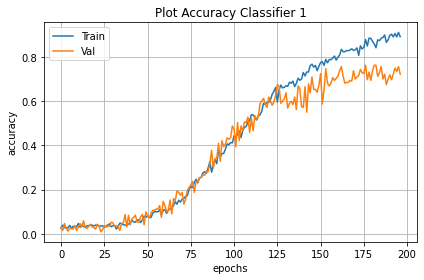

In [44]:
plt.plot(history1.history['accuracy'], label='Train')
plt.plot(history1.history['val_accuracy'], label='Val')

plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title("Plot Accuracy Classifier 1")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

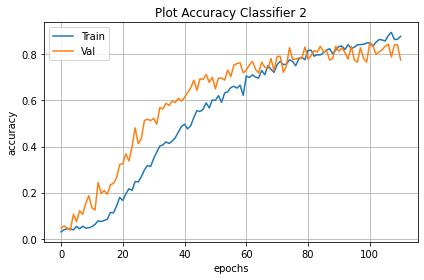

In [45]:
plt.plot(history2.history['accuracy'], label='Train')
plt.plot(history2.history['val_accuracy'], label='Val')

plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title("Plot Accuracy Classifier 2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

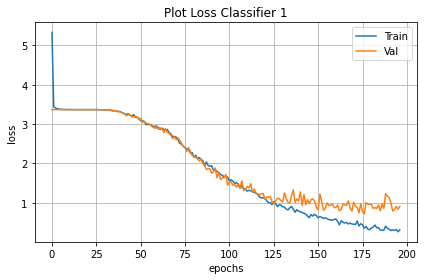

In [46]:
plt.plot(history1.history['loss'], label='Train')
plt.plot(history1.history['val_loss'], label='Val')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.title("Plot Loss Classifier 1")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

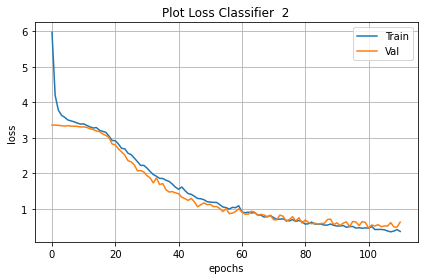

In [47]:
plt.plot(history2.history['loss'], label='Train')
plt.plot(history2.history['val_loss'], label='Val')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.title("Plot Loss Classifier  2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Fine Tuning

In [48]:
base_model.trainable = True

In [49]:
# Tampillkan Jumlah Layer pada Model
print("Jumlah Layer pada Model Classifier 2 adalah {}".format(len(base_model.layers)))

Jumlah Layer pada Model Classifier 2 adalah 20


In [50]:
# Fine Tune dimulai pada layer 16
start_fine_tune = 16
for i in base_model.layers[:start_fine_tune]:
  i.trainable = False

In [51]:
opt2 = RMSprop(learning_rate = 0.0001)
Classifier2.compile(loss='categorical_crossentropy', optimizer = opt2, metrics=['accuracy'])

In [52]:
Classifier2.summary()

Model: "ImageClassifier_with_VGG16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 flatten_1 (Flatten)         (None, 512)               0         
                                                                 
 dense_6 (Dense)             (None, 2048)              1050624   
                                                                 
 dropout_5 (Dropout)         (None, 2048)              0         
                                                                 
 dense_7 (Dense)             (None, 1024)              2098176   
                                                                 
 dropout_6 (Dropout)         (None, 1024)              0         
                                                                 
 dense_8 (Dense)             (None, 512)

In [53]:
es3 = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 10)
mc3 = ModelCheckpoint('best_model3.h5', monitor = 'val_accuracy', mode = 'max', verbose = 1, save_best_only = True)

In [54]:
history3 = Classifier2.fit(
    train_generator2, 
    steps_per_epoch = 80,
    epochs = 100, 
    validation_data = validation_generator2,
    validation_steps = 20,
    verbose = 1,
    callbacks=[es3, mc3]
    )

Epoch 1/100
80/80 [==============================] - ETA: 0s - loss: 0.9133 - accuracy: 0.7633
Epoch 00001: val_accuracy improved from -inf to 0.77188, saving model to best_model3.h5
80/80 [==============================] - 13s 136ms/step - loss: 0.9133 - accuracy: 0.7633 - val_loss: 0.7602 - val_accuracy: 0.7719
Epoch 2/100
80/80 [==============================] - ETA: 0s - loss: 0.6873 - accuracy: 0.8094
Epoch 00002: val_accuracy did not improve from 0.77188
80/80 [==============================] - 10s 128ms/step - loss: 0.6873 - accuracy: 0.8094 - val_loss: 0.7491 - val_accuracy: 0.7563
Epoch 3/100
80/80 [==============================] - ETA: 0s - loss: 0.5982 - accuracy: 0.8367
Epoch 00003: val_accuracy improved from 0.77188 to 0.85938, saving model to best_model3.h5
80/80 [==============================] - 11s 131ms/step - loss: 0.5982 - accuracy: 0.8367 - val_loss: 0.3545 - val_accuracy: 0.8594
Epoch 4/100
80/80 [==============================] - ETA: 0s - loss: 0.5210 - accurac

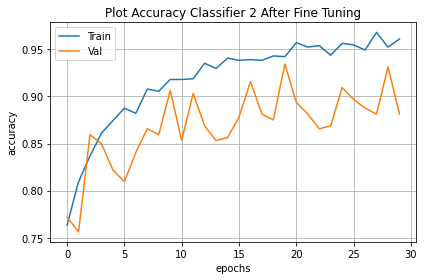

In [55]:
plt.plot(history3.history['accuracy'], label='Train')
plt.plot(history3.history['val_accuracy'], label='Val')

plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title("Plot Accuracy Classifier 2 After Fine Tuning")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

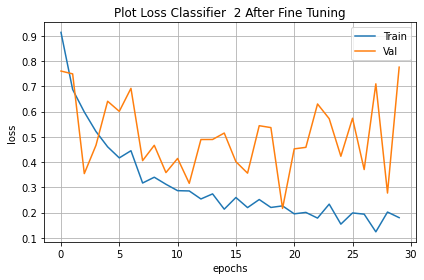

In [56]:
plt.plot(history3.history['loss'], label='Train')
plt.plot(history3.history['val_loss'], label='Val')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.title("Plot Loss Classifier  2 After Fine Tuning")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Part 7: Test Model

In [57]:
 print(train_generator.class_indices)

{'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'J': 9, 'K': 10, 'L': 11, 'M': 12, 'N': 13, 'O': 14, 'P': 15, 'Q': 16, 'R': 17, 'S': 18, 'T': 19, 'U': 20, 'V': 21, 'W': 22, 'X': 23, 'Y': 24, 'Z': 25, 'del': 26, 'nothing': 27, 'space': 28}


In [58]:
best_model_dir1 = '/content/best_model.h5'
model1 = load_model(best_model_dir1)

In [59]:
best_model_dir2 = '/content/best_model3.h5'
model2 = load_model(best_model_dir2)

In [60]:
def visualize_image(path, model, asl_name):
  fig, xfig = plt.subplots()
  img = image.load_img(path, target_size=(150,150))
  imgplot = xfig.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=16)
  output_class = np.argmax(classes)
  
  if output_class == 0:
    xfig.set_title(asl_name + " | Pred: A")
  elif output_class == 1:
    xfig.set_title(asl_name + " | Pred: B")
  elif output_class == 2:
    xfig.set_title(asl_name + " | Pred: C")
  elif output_class == 3:
    xfig.set_title(asl_name + " | Pred: D")
  elif output_class == 4:
    xfig.set_title(asl_name + " | Pred: E")
  elif output_class == 5:
    xfig.set_title(asl_name + " | Pred: F")
  elif output_class == 6:
    xfig.set_title(asl_name + " | Pred: G")
  elif output_class == 7:
    xfig.set_title(asl_name + " | Pred: H")
  elif output_class == 8:
    xfig.set_title(asl_name + " | Pred: I")
  elif output_class == 9:
    xfig.set_title(asl_name + " | Pred: J")
  elif output_class == 10:
    xfig.set_title(asl_name + " | Pred: K")
  elif output_class == 11:
    xfig.set_title(asl_name + " | Pred: L")
  elif output_class == 12:
    xfig.set_title(asl_name + " | Pred: M")
  elif output_class == 13:
    xfig.set_title(asl_name + " | Pred: N")
  elif output_class == 14:
    xfig.set_title(asl_name + " | Pred: O")
  elif output_class == 15:
    xfig.set_title(asl_name + " | Pred: P")
  elif output_class == 16:
    xfig.set_title(asl_name + " | Pred: Q")
  elif output_class == 17:
    xfig.set_title(asl_name + " | Pred: R")
  elif output_class == 18:
    xfig.set_title(asl_name + " | Pred: S")
  elif output_class == 19:
    xfig.set_title(asl_name + " | Pred: T")
  elif output_class == 20:
    xfig.set_title(asl_name + " | Pred: U")
  elif output_class == 21:
    xfig.set_title(asl_name + " | Pred: V")
  elif output_class == 22:
    xfig.set_title(asl_name + " | Pred: W")
  elif output_class == 23:
    xfig.set_title(asl_name + " | Pred: X")
  elif output_class == 24:
    xfig.set_title(asl_name + " | Pred: Y")
  elif output_class == 25:
    xfig.set_title(asl_name + " | Pred: Z")
  elif output_class == 26:
    xfig.set_title(asl_name + " | Pred: Del")
  elif output_class == 27:
    xfig.set_title(asl_name + " | Pred: Nothing")
  elif output_class == 28:
    xfig.set_title(asl_name + " | Pred: Space")

### Classifier 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


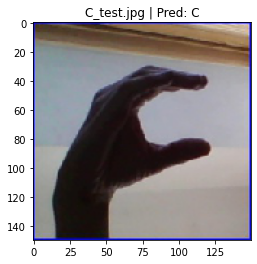

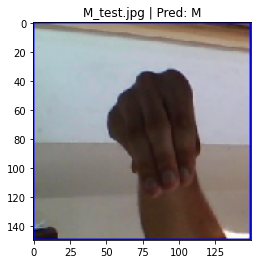

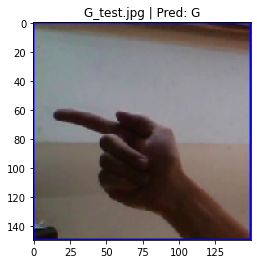

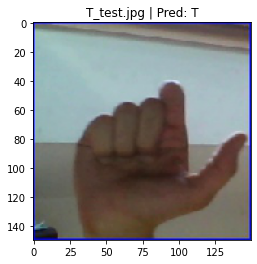

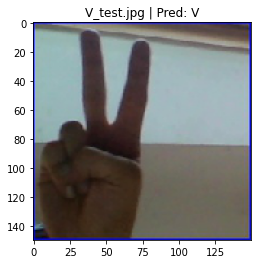

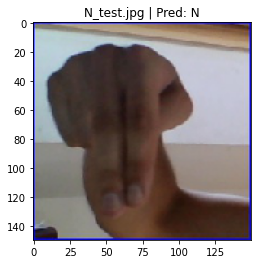

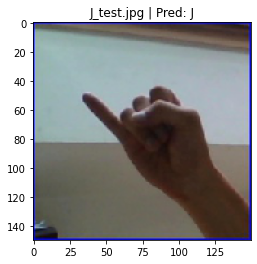

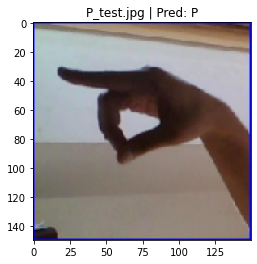

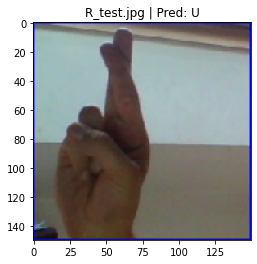

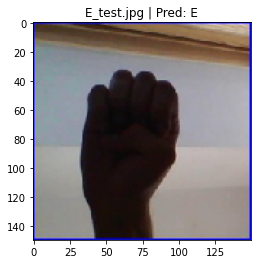

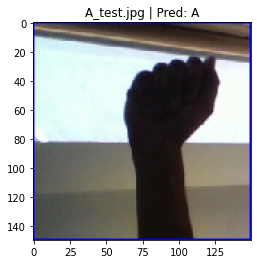

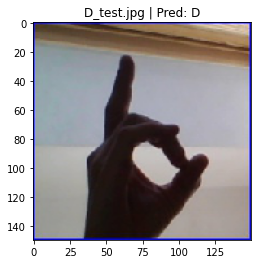

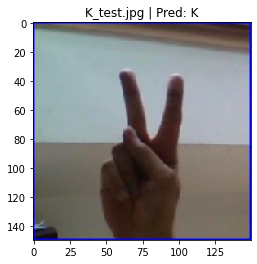

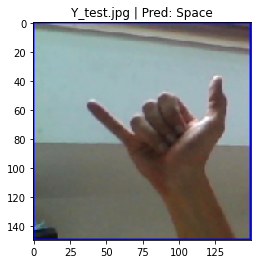

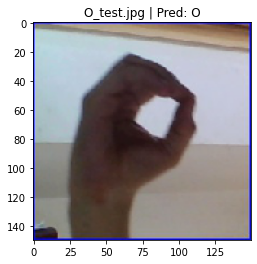

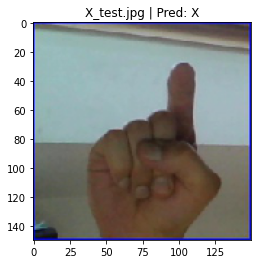

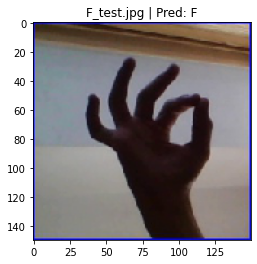

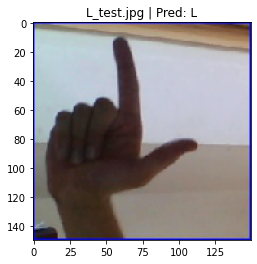

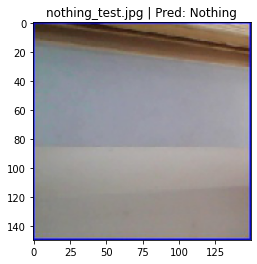

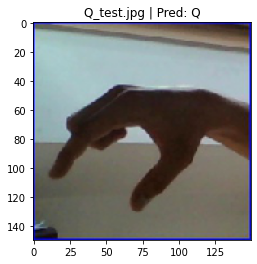

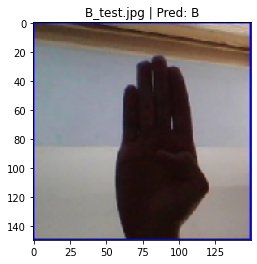

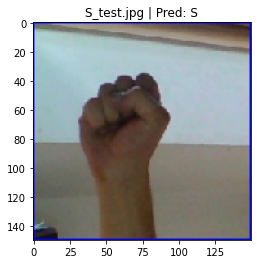

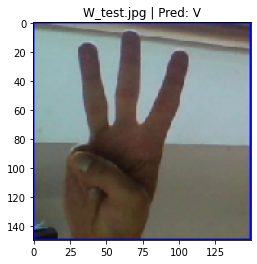

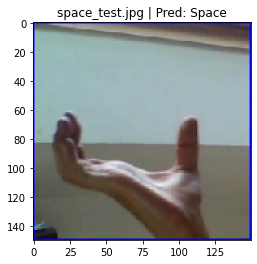

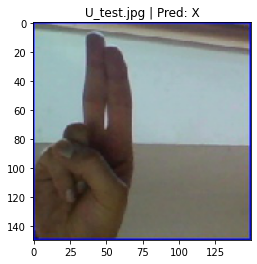

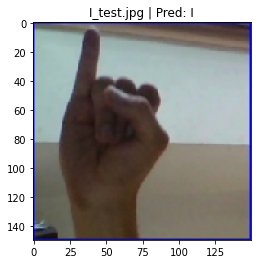

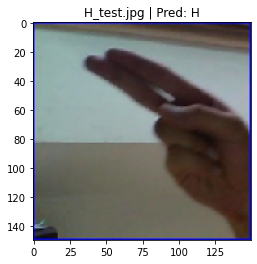

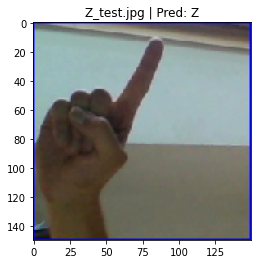

In [61]:
test_dir = '/content/asl_alphabet_test/asl_alphabet_test'
for i in os.listdir(test_dir):
  path = os.path.join(test_dir, i)
  visualize_image(path=path, model=model1, asl_name=i)

### Classifier 2

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


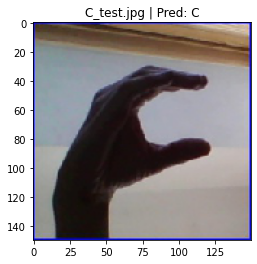

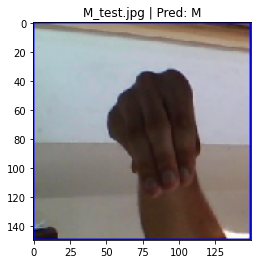

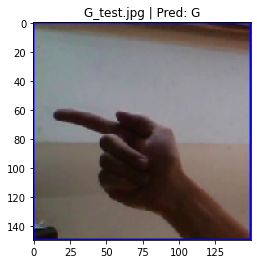

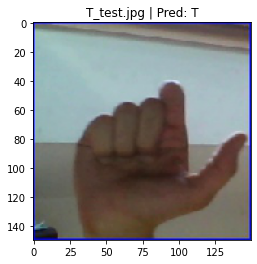

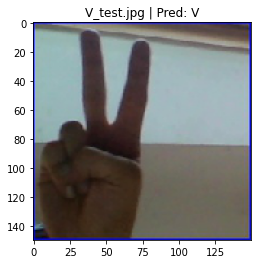

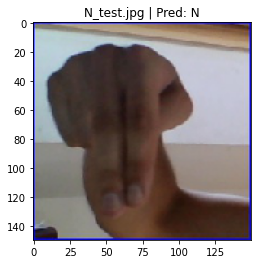

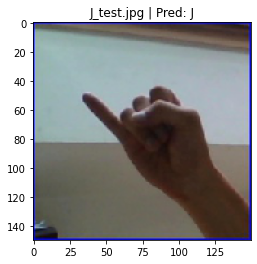

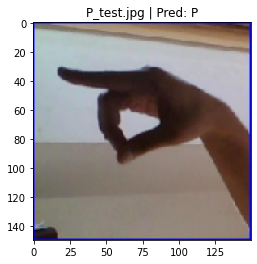

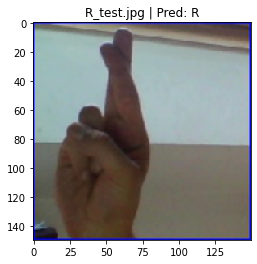

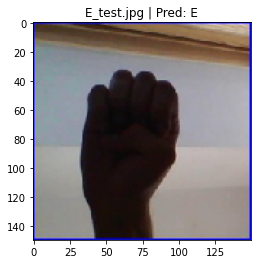

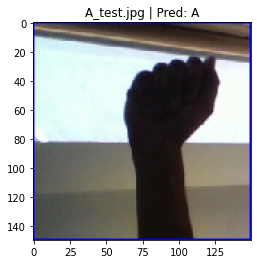

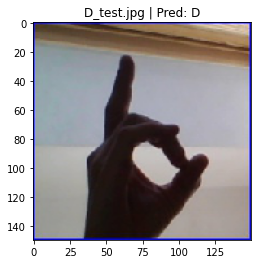

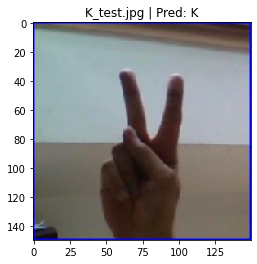

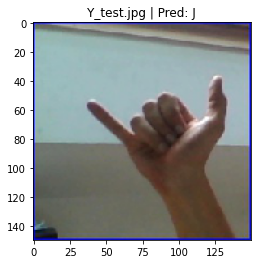

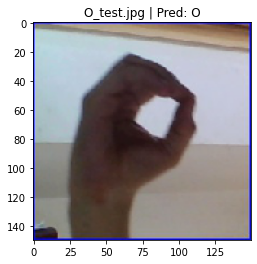

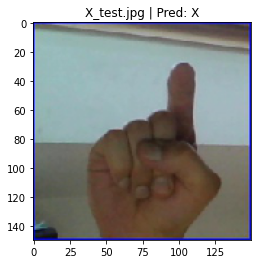

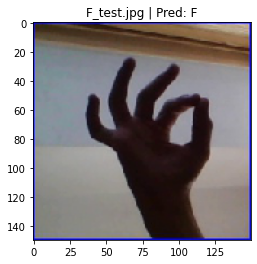

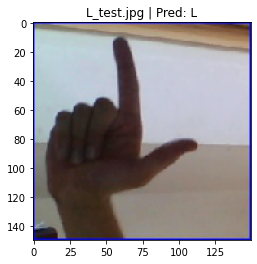

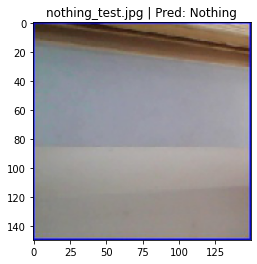

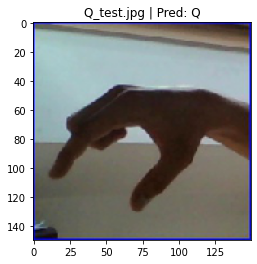

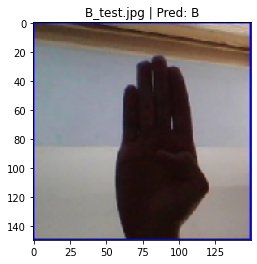

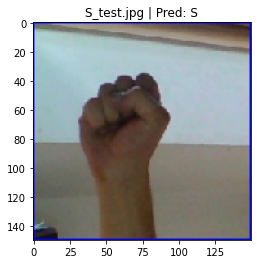

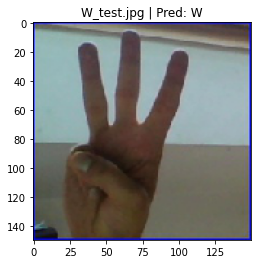

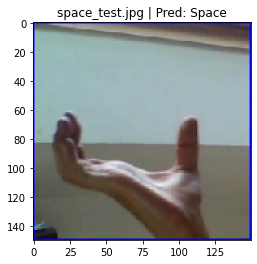

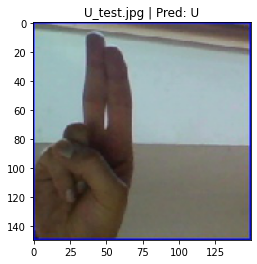

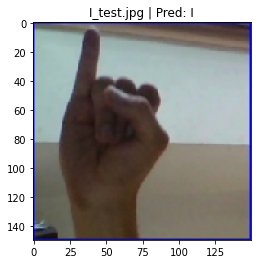

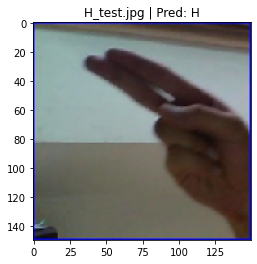

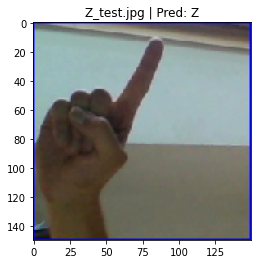

In [62]:
for i in os.listdir(test_dir):
  path = os.path.join(test_dir, i)
  visualize_image(path=path, model=model2, asl_name=i)

## Kesimpulan

Di sini, telah dibuat 2 model image classifier dengan struktur model berbeda. Model pertama adalah model yang dibuat dan dilatih dari nol dengan memanfaatkan beberapa layer seperti Conv2D, MaxPooling, dan Dense. Sementara model kedua memanfaatkan pre-trained model VGG16 dan dilakukan transfer learning serta fine-tuning. <br>

Dari proses pelatihan, dapat dilihat bahwa model Classifier 1 mampu mencapai level akurasi training di atas 80%, tetapi hanya mampu meraih akurasi validasi di angka 75%. Untuk Classifier 2, dengan transfer learning dan fine-tuning, nilai akurasi training dan validasi di atas 90%, sehingga model kedua terlihat lebih superior.<br>

Hal ini sesuai dengan saat pengetesan. Pada saat pengetesan untuk memprediksi gambar, dapat dilihat bahwa model 1 (Classifier 1) mengalami salah prediksi sebanyak 5 kali, tetapi model 2 (Classifier 2) hanya mengalami kesalahan 1 kali. Dengan begitu, model 2 lebih diunggulkan untuk diaplikasikan pada sistem klasifikasi pada android.<br>

## Konversi Ke TFLite

In [63]:
# Konversi model.
converter1 = tf.lite.TFLiteConverter.from_keras_model(model1)
tflite_model1 = converter1.convert()

INFO:tensorflow:Assets written to: /tmp/tmpsuox9erh/assets


In [64]:
with tf.io.gfile.GFile('model.tflite', 'wb') as f:
  f.write(tflite_model1)

In [65]:
converter2 = tf.lite.TFLiteConverter.from_keras_model(model2)
tflite_model2 = converter2.convert()

with tf.io.gfile.GFile('model.tflite2', 'wb') as f:
  f.write(tflite_model2)

INFO:tensorflow:Assets written to: /tmp/tmp8u3furt6/assets


INFO:tensorflow:Assets written to: /tmp/tmp8u3furt6/assets
